### Clustering jerárquico 

El clustering jerárquico va uniendo objetos de a pares en función de la distancia que los separa. Una vez que fusiona dos objetos, calcula la distancia entre el conjunto y un objeto individual la calcula según distintos criterios (puede ser tomando la distancia promedio entre el objeto y el conjunto, la distancia mínima, máxima, etc.).

Acá vamos a ver cómo funciona para el conjunto de documentos de prueba, en caso que se utilize **NMF** con más tópicos que los 4 esperados.

Comenzamos aplicando **NMF** a la matriz *tf-idf* del corpus, con por ejemplo 8 tópicos (los objetos que carga vienen de los tutoriales anteriores):

In [1]:
import cPickle as pk
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc

# Cargado del diccionario construido
dictionary = Dictionary.load('tutorial.dict')

# Cargado del corpus como tfidf
corpus_tfidf = pk.load(file('Tutorial_corpus_tfidf.pk','r'))

# Corpus para sklearn
corpus2sklearn = corpus2csc(corpus_tfidf).T

# Objeto nmf a partir de la clase NMF
nmf = NMF(n_components = 8, random_state=123457)

# Transformamos el corpus como tfidf al espacio de tópicos
corpus_transformed = nmf.fit_transform(corpus2sklearn)

# Imprimimos los términos de cada tópico
nt = 0 # Indice auxiliar
for c in nmf.components_:
    
    m = len(c)
    l = range(m)
    ordered_index_list = sorted(l, reverse = True, key = lambda x: c[x])
    topic_terms = [dictionary[i] for i in ordered_index_list[:10]]
    print(u'Tópico {}: '.format(nt) + u', '.join(topic_terms))

    nt += 1

Tópico 0: aborto, vida, mujeres, mujer, embarazo, salud, ley, debate, despenalización, derecho
Tópico 1: dólar, inflación, bcra, mercado, tasa, tasas, suba, us, central, precios
Tópico 2: boca, river, copa, pavón, equipo, partido, superliga, libertadores, guillermo, barros
Tópico 3: acero, aranceles, comercial, aluminio, china, trump, comercio, exportaciones, productos, estados
Tópico 4: kim, corea, norte, cumbre, trump, jong, singapur, nuclear, pyongyang, norcoreano
Tópico 5: diputados, debate, proyecto, discusión, legalización, aborto, comisión, iniciativa, comisiones, legislación
Tópico 6: trump, siria, blanca, ataque, presidente, casa, estados, washington, unidos, donald
Tópico 7: centavos, dólar, mayorista, divisa, banco, bancos, mercado, segmento, cerró, entidades


Observamos que hay tópicos que tienen palabras clave repetidas, por lo tanto podrían considerarse (o no, tal vez la división es además informativa) como parte de un mismo macro-tópico. La idea es entonces cuantificar qué tan parecidos son entre ellos y observar si podemos tomar algún criterio para juntarlos.

En principio podemos cuantificar la similitud con la distancia coseno.

In [2]:
from scipy.spatial.distance import cosine

print('Distancia coseno entre 1 y 2: {}'.format(cosine(nmf.components_[1], nmf.components_[2])))
print('Distancia coseno entre 1 y 7: {}'.format(cosine(nmf.components_[1], nmf.components_[7])))


Distancia coseno entre 1 y 2: 0.902685752032
Distancia coseno entre 1 y 7: 0.562462974411


Si bien vemos que la distancia entre tópicos parecidos es menor, podemos enfatizar esta diferencia mediante una reducción de la dimensionalidad. Lo realizamos con **Singular Value Decomposition**:

In [3]:
from sklearn.decomposition import TruncatedSVD

# Ponemos por ejemplo la mitad de las dimensión más chica 
# Recordar que si aplicamos SVD con la cantidad de componentes igual
# a la dimensión más chica de la matriz que queremos reducir,
# simplemente es un cambio de base y no hay pérdida de la información,
# necesaria para obtener abstracción en la interpretación de los tópicos.
svd = TruncatedSVD(n_components=4)

nmf_reduced = svd.fit_transform(nmf.components_)

print('Cantidad de información retenida {}'.format(sum(svd.explained_variance_ratio_)))
print('Dimensiones de la matriz de tópicos reducida: {}'.format(nmf_reduced.shape))

Cantidad de información retenida 0.660177587671
Dimensiones de la matriz de tópicos reducida: (8, 4)


Vemos cómo varió la distancia en la matriz reducida:

In [4]:
print('Distancia coseno entre 1 y 2: {}'.format(cosine(nmf_reduced[1], nmf_reduced[2])))
print('Distancia coseno entre 1 y 7: {}'.format(cosine(nmf_reduced[1], nmf_reduced[7])))

Distancia coseno entre 1 y 2: 0.870746055822
Distancia coseno entre 1 y 7: 0.0169970595703


Vemos que aquellos tópicos parecidos se acercaron, mientras los diferentes mantuvieron la distancia.

#### Dendrograma

Aquí realizamos el clustering jerárquico y la construcción del dendrograma. **Scipy** tiene funciones para hacerlo.

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram

Con la función *linkage* ligamos los tópicos. El parámetro *method* se refiere al criterio que toma para unir un objeto con un conjunto de objetos (clusterizados en algún paso anterior), y podemos además indicar la métrica (en caso que haga falta usar una métrica que no venga por default se puede pasar como argumento la matriz con las distancias ya precalculadas). Ver la documentación de [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

In [6]:
# Z es todo el clustering realizado
Z = linkage(nmf_reduced, method='single', metric='cosine')

Finalmente gráficamos. Para ello utilizamos además la función *dendrogram*:

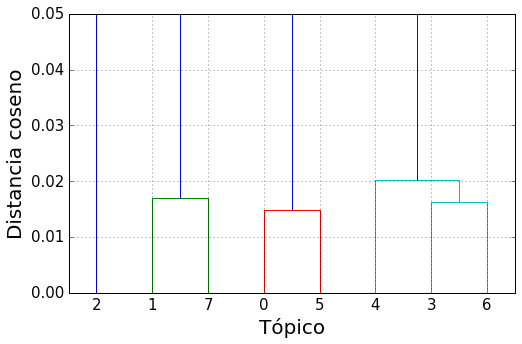

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 5))

# Esta función construye el dendrograma a partir de Z
dn = dendrogram(Z)

plt.ylim([0.00, 0.05])
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(u'Tópico', size = 20)
plt.ylabel('Distancia coseno', size = 20)
plt.grid('on')
plt.show()

Según la documentación de la función [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) las ramas con un color diferente al azul indica que la distancia está por debajo de una distancia crítica, por lo que sugiere que los tópicos ligados con el mismo color pueden considerarse fusionados. Un estudio más cuantitativo consistiría en medir coeficientes como la silhouette para evaluar la bondad de la partición.

En este ejemplo funciona bastante bien: el clustering jerárquico nos sugiere fusionar aquellos tópicos que naturalmente consideraríamos parecidos, obteniendo finalmente los 4 tópicos que esperábamos en el conjunto de prueba.

#### Interpretación del objeto Z

Esto puede ser útil en caso que se quiera construir un dendrograma con otros datos.
Z tiene dimensiones de (n-1) por 4, donde n es la cantidad de objetos que queremos clusterizar (en nuestro caso 8).

Cada fila es una iteración: los dos primeros componentes de la fila son los objetos que liga, la tercer componente la distancia entre ellos, y el cuarto la cantidad de objetos incluídos en esa fusión.

In [8]:
# Por ejemplo:
# En la primer iteración Z liga el tópico 0 con el 5, distanciados a 0.014758,
# y al fusionarlos crea un nuevo objeto que contiene a dos objetos originales.

print(Z[0])

[0.         5.         0.01478426 2.        ]


cada vez que liga dos objetos en uno nuevo, lo nombra con la menor etiqueta posible. Así como acá tenemos objetos del 0 al 7, la primer fusión que hace la denomina 8. Veamos la matriz Z en su totalidad:

In [9]:
print(Z)

[[ 0.          5.          0.01478426  2.        ]
 [ 3.          6.          0.01634422  2.        ]
 [ 1.          7.          0.01699706  2.        ]
 [ 4.          9.          0.02025532  3.        ]
 [ 8.         11.          0.6867104   5.        ]
 [10.         12.          0.6948704   7.        ]
 [ 2.         13.          0.78051292  8.        ]]


La fusión entre el elemento 4 y el 9 (*Z[3]*) es en realidad la fusión entre el elemento 4 y el objeto creado de la fusión entre 3 y 6. Se indica la distancia entre el objeto 4 y el 9, y al fusionarlos se indica que el nuevo objeto contiene 3 de los objetos originales.